In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# read insurance data
data = pd.read_csv('insurance.csv')

train = data.sample(round(data.shape[0]*0.8)) # 80% i.e. 
test = data.drop(train.index)

# Splitting dataset into smoker vs non-smoker
smoker_train = train[train.smoker == 'yes']
nonsmoker_train = train[train.smoker == 'no']

## Background / Motivation

The healthcare system in the United States is deeply flawed, and its citizens suffer, potentially fatally, as a result. According to a poll from the University of Chicago, 40% of Americans report skipping a recommended medical test or treatment and 44% say they didn’t go to a doctor when they were sick or injured in the last year [3]. These high medical costs make health insurance an invaluable resource. However, health insurance can serve as another barrier to receiving proper medical care; not only can health insurance itself be very costly, but the health insurance system lacks transparency, and consumers may not understand where their money is going and how it translates to the medical care they receive. 

Consumers pay an upfront premium routinely that can be used to cover their medical costs down the line. Insurance companies determine the total premium they need to collect based on projected medical costs for all the consumers enrolled in a given plan, and determine the individual premium a consumer pays based on their personal characteristics (as they may translate to risk factors) [2]. Beyond this general overview of health insurance premiums, over the course of this report, we will attempt to develop a model that explains exactly how much a given individual will be expected to pay for their personal yearly health insurance premium.

## Problem statement 

The objective of this report is to shed light on how insurance is priced for consumers and what factors play a role, particularly in regards to the consumer’s lifestyle choices and personal characteristics. The resulting model should provide clarity to individuals who are curious about why they pay how much they pay for health insurance or potentially help consumers estimate how much they will be required to pay for their health insurance. This is a prediction problem.

## Data sources

Our data source was the open source dataset “Medical Cost Personal Datasets” from Kaggle (link can be found in references). This csv file includes observations of individual medical costs billed by health insurance and six potential predictor variables, including age, sex, body mass index, number of children, region of residence, and smoking history. The data is taken from 1338 individuals in the United States. 

The distribution for region and sex was even across all categories, but the data was not evenly split across smoking history: 15% of observations were smokers, while 85% were not. The distribution for BMI was unimodal and symmetric, and the distributions for age, number of children and charges were unimodal and right-skewed. 

We did not anticipate any issues due to the nature of the dataset. There was no missing data or need for imputation. 


## Stakeholders
Our report will be beneficial for our primary stakeholders, health insurance consumers. Using our model, individual consumers can get an estimate of how much they will have to pay for health insurance each year based on their age, sex, BMI, number of children, smoking history, and location. This knowledge could be beneficial for budgeting purposes, as well as serve as a baseline if they are comparing rates from different health insurance providers. This could also better their understanding of health insurance and provide them with more transparency on the system. 

Moreover, our report may be beneficial for health insurance providers and healthcare providers since these are the parties that monetarily profit off of health insurance. If this model changes consumers’ expectations for health insurance pricing, or if consumers make different decisions about their health insurance provider based on the model, health insurance providers may have to adjust the structure of their policies or provide more competitive pricing. Furthermore, with the help of this model, healthcare providers will have a better understanding of their patients and how they are paying for their services. Potentially, this could adjust how healthcare providers bill their patients. 


## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

If the tables in this section take too much space, you may put them in the appendix, and just mention any useful insights you obtained from the data quality check that helped you develop the model or helped you realize the necessary data cleaning / preparation.

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did you do any data wrangling or data preparation before the data was ready to use for model development? Did you create any new predictors from exisiting predictors? For example, if you have number of transactions and spend in a credit card dataset, you may create spend per transaction for predicting if a customer pays their credit card bill. Mention the steps at a broad level, you may put minor details in the appendix. Only mention the steps that ended up being useful towards developing your final model(s).

## Exploratory data analysis

Put the relevant EDA here (visualizations, tables, etc.) that helped you figure out useful predictors for developing the model(s). Only put the EDA that ended up being useful towards developing your final model(s). 

List the insights (as bullet points) you got from EDA that ended up being useful towards developing your final model. 

Again, if there are too many plots / tables, you may put them into appendix, and just mention the insights you got from them.

Before creating our model, we performed EDA on all seven factors by visualizing their distribution and relationship to charges. From this exploration, we identified the three major contributors to charge are smoker, age and bmi, as well as discovered some potential interaction terms that could prove useful.

Firstly, we started exploration of the smoker data to see if there were any significant differences between the two groups (smoker vs non-smoker) in terms of charge. 

<AxesSubplot:xlabel='smoker', ylabel='charges'>

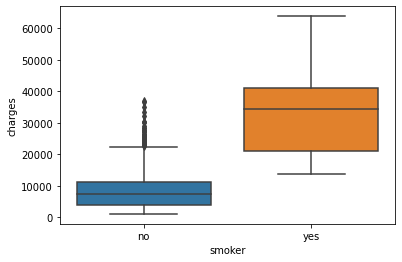

In [13]:
# Relationship between smoker vs charge
sns.boxplot(x = 'smoker', y = 'charges', data = train)

- The median charge for smokers is much higher than that of non smokers by approximately USD 30,000. 
- While there was some overlap in the whiskers of the boxplots, because the boxes of both categories had no overlaps, we positted that these distinctions would make a significant in our model. 

Secondly, we explored the relationship between bmi and charges. Since we couldn't discern a trend for the entire dataset, we decided to graph separate plots for smokers and nonsmokers to investigate of there is a clearer bmi-charge relationship for one of the groups.

non-smoker


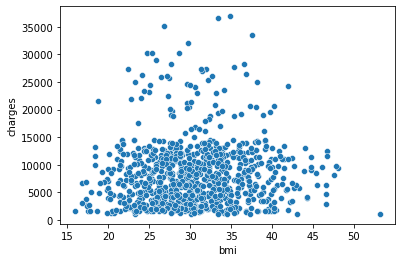

smoker


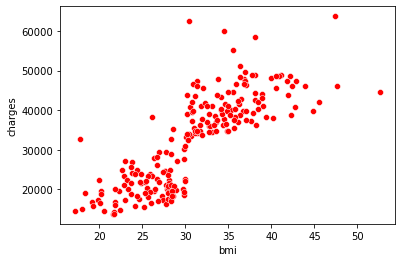

In [14]:
# Scatterplot of bmi vs age 
print('non-smoker')
sns.scatterplot(data = nonsmoker_train, x = 'bmi', y = 'charges')
plt.show()
print('smoker')
sns.scatterplot(data = smoker_train, x = 'bmi', y = 'charges', color = 'red')
plt.show()

- The separate graphs for each smoker class shows that there is a clearer positive relationship between bmi and charges for smokers. 
- However, such a relationship is not as clear for non-smokers.

In order to make sense of the bmi-charges in the non-smoker data, we decided to bin the bmi based on the CDC cutoff for underweight, normal, overweight, obese and morbidly obsese bmi ranges. This would help reduce the noise in the data and also contextualize the data interms of its implications of an individual's health condition. The boxplot of the binned bmi variable ('bmi_binned') vs charges shows an increasing median charge and larger spread for higher bmi categories, suggesting a positive relationship between bmi and charges.

<AxesSubplot:xlabel='bmi_binned', ylabel='charges'>

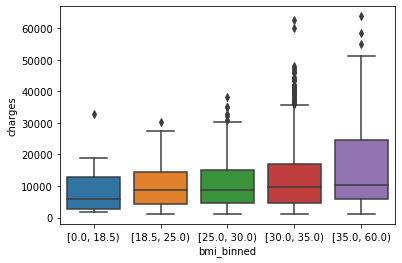

In [16]:
# bin bmi based on cdc cutoff for underweight, normal, overweight, obese, morbidly obese
binned_bmi = pd.cut(train['bmi'], [0,18.5,25,30,35,60], right = False, retbins = True)
bins = [0,18.5,25,30,35,60]


train['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)
test['bmi_binned'] = pd.cut(data['bmi'], bins = bins, right = False)

# boxplot of binned bmi
sns.boxplot(data = train, x = 'bmi_binned', y = 'charges')

Thirdly, we were interested in observing the relationship between age vs charge. 

<AxesSubplot:xlabel='age', ylabel='charges'>

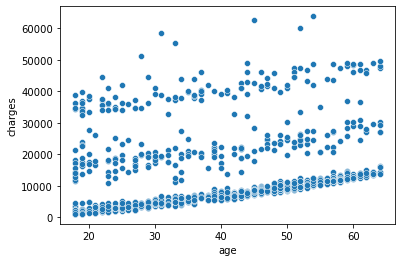

In [17]:
# Relationship between age vs charge
sns.scatterplot(data = train, x = 'age', y = 'charges')

- The scatterplot confirmed our intuition that higher age correlates positively with higher charges. 
- However, we didn't expect the graph to show three distinct lines, with three different intercepts. 

Believing that these distinctions are probably due to a third factor, we subset the data into smoker and non-smoker categories and replotted the scatterplot of age vs charge for each group. The plot confirmed our suspicion: the distinct lines comes from the smoker non-smoker variable where smokers have a higher baseline charge as seen by the intercept. 

Non-smoker


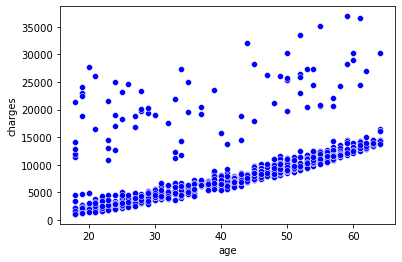

Smoker


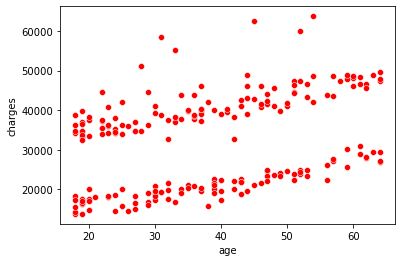

Combined


<AxesSubplot:xlabel='age', ylabel='charges'>

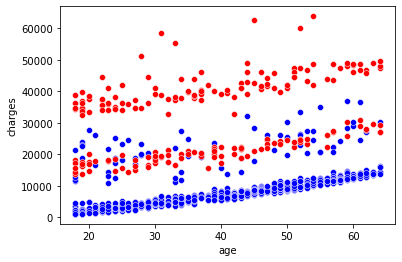

In [18]:
# Scatterplot of non-smoker age vs charge
print('Non-smoker')
sns.scatterplot(data = nonsmoker_train, x = 'age', y = 'charges', color = 'blue')
plt.show()

# Scatterplot of smoker age vs charge
print('Smoker')
sns.scatterplot(data = smoker_train, x = 'age', y = 'charges', color = 'red')
plt.show()

# Combined plot
print('Combined')
sns.scatterplot(data = nonsmoker_train, x = 'age', y = 'charges', color = 'blue')
sns.scatterplot(data = smoker_train, x = 'age', y = 'charges', color = 'red')

- Interestingly, the smoker subset still had two separate lines. One group with charges below USD 30,000 and one above. 
- The summary data table below takes the difference between the quantitative variables of the group above USD 30000 and the group below 30000. The variable that is different between the two groups is bmi. (Mean bmi for over USD 30,000 group was in the morbidly obese category, but only in the overweight category for the under USD 30,000 group.)
- This suggests that bmi and smoker may interact to influence charges. Hence, an interaction variable for smoker*bmi_binned should be included.

In [25]:
# Look for difference in smoker age v charge graphs for above $30k group and below $30k group
over30 = smoker_train[smoker_train.charges > 30000]
under30 = smoker_train[smoker_train.charges < 30000]

# Summary stats tables for the two groups
over30_stats = pd.DataFrame(over30.describe())
under30_stats = pd.DataFrame(under30.describe())

# Take difference in summary stats, values above 0 suggest source of difference between teh groups
(over30_stats - under30_stats).iloc[:,0:3]

,age,bmi,children
count,29.000000,29.000000,29.000000
mean,0.407721,9.980250,0.054380
std,0.659753,1.576192,-0.045958
min,0.000000,0.570000,0.000000
25%,-2.000000,8.763750,0.000000
50%,-1.000000,8.960000,0.000000
75%,2.000000,9.775000,0.000000
max,0.000000,22.580000,-1.000000


## Approach

We used a linear regression for our model because our dependent variable, yearly insurance charges, was measured in USD, which is continuous rather than discrete. We thought our model would be more useful if we could predict exact charges for an individual rather than just a level (low, medium, high). In our exploratory analysis, we determined the distribution of charges was skewed-right and unimodal; there were no natural breaks in the data where we could easily demarcate boundaries for levels or categories. Moreover, if we had created categories for charges (low, medium, high), these categories would be unevenly weighted, due to the right-skew, which could create issues for testing our model. Using a linear model would avoid these issues.

The performance metrics we optimized were R-squared, RMSE, and RSE. We wanted an R-squared value as close to 100% as possible because this would mean through our model was very precise in predicting charges and that charges could be explained by the predictors and interactions we determined; however, this was not our main focus because R squared increases monotonically as long as variables are added to the model, which does not mean the model is necessarily bettered by the inclusion of these variables. We wanted to minimize RMSE because this would mean we minimized the average difference between the predicted and actual values for charges. Our target for RMSE was ~$3,000 because insurance charges vary from ~$1,100-64,000. We wanted to minimize RSE for similar reasons and also wanted it to be as close to RMSE as possible because this would mean our model avoided overfitting.
One problem we anticipated was that our dataset only included six potential predictors. While this made the data easy to understand and clean, we were concerned this would be an oversimplification of how insurance works because there could be many other factors that come into play (occupationl, type of coverage for insurance plan, etc). 

Our first model predicted charges based on the six predictors, with no interactions or transformations. This gave us an R-squared of 0.763 and an RMSE of $5998, both of which were far from our target values. In the process of developing our model, we decided to bin BMI, use an interaction between BMI and smoking history, and transform age quadratically. These changes improved our model. We detail our reasoning for these changes in the following section. 

Our problem did not have pre-posted solutions. 



## Developing the model

Explain the steps taken to develop and improve the base model - informative visualizations / addressing modeling assumption violations / variable transformation / interactions / outlier treatment / influential points treatment / addressing over-fitting / addressing multicollinearity / variable selection - stepwise regression, lasso, ridge regression). 

Did you succeed in achieving your goal, or did you fail? Why?

**Put the final model equation**.

**Important: This section should be rigorous and thorough. Present detailed information about decision you made, why you made them, and any evidence/experimentation to back them up.**

#### Modifying the initial model

Based on analysis of the residuals plots from our preliminary model, it was clear that age needed to be transformed given the parabolic shape of its residual graph (which violates the linearity assumption). Hence, we performed a transformation by raising age to the power of 2, based on the observed shape of the plot. 

Moreover, we decided to train and test our model using another randomized subset of data. This time, we chose to stratify our training data by age in order to ensure proportional representation of each age group in both our training and our test data. We chose to stratify based on age given that is has a strong positive relationship with charge and thus is an important predictor in our model. By preserving the proportion of age groups in the data, we ensure that this characteristic is properly represented in both training and test samples.

Our new model ended up having a lower RMSE of USD 3898.77. This indicates that we improved the accuracy of the model with the transformation. Moreover, the residual plot shows that the age residual plot is no longer curved and thus linearity is not violated.

#### Outliers and Influential Points

An outlier test obtained by plotting the fitted values of the model against the studentized residuals revealed 52 outliers (out of 1070 training observations) in the model. Although the outliers make up less than 5% of the training observations, it was still necessary to investigate why these outliers existed, and if they affected the quality of the model. The high leverage test (using a leverage cutoff of 4 times the average leverage) revealed that there were 17 high leverage points in the training dataset, but only 1 was a highly influential point (high leverage and outlier). Although removing the influential point decreased RMSE, the difference between the model RMSE with and without the influential point was very small– it was about a 27 cent difference (from 3898.77 to 3898.49 dollars). Additionally, RSE increased (from 4541.86 to 4543.78) and the R-squared of the model stayed the same at 0.865. Overall, the quality of the model did not improve significantly. This remained the case after testing for outliers with multiple values in np.random.seed()-- in fact, the model without the influential point performed worse on all 3 metrics (RMSE, RSE, and R-squared) on multiple random seed values. To further our understanding of the causes for the outliers, we investigated the trends between the predictors and the outliers. While all of the other predictors had a normal distribution in the outliers, over 82% of the outliers were non-smokers. Thus, we came to the conclusion that there must be some predictors that are not represented in our dataset which are causing these skews. We also chose to keep all outliers and the influential point in the datasets for developing the model because we believe that they remain significant in creating an accurate model, and additional information (such as more predictors) would be needed to consider removing them. 

## Limitations of the model with regard to inference / prediction

The information related to the predictors in our model will be very convenient to acquire for all stakeholders. The predictors in our model are all related to an individual’s health and general demographics (age, smoking history, bmi, region of residence, number of children, sex). Our stakeholders who are consumers of health insurance plans will get results from our model immediately, since they already have the predictor information on hand. It is the same case for healthcare workers (such as medical offices or hospitals. They already have the patient’s information on hand, so getting results from our model will also be immediate for these stakeholders. Our stakeholders who are the healthcare insurance companies will need to acquire information from potential customers before using our model to predict what prices they should be charging. This collection of information is simple for them because they will simply request for information from potential customers. They can then use the model and get results immediately. 

One point of concern in our model is the lack of some information that would be significant predictors in an insurance premium prediction model. This would include an individual’s income level, job occupation, and whether they would like a more basic or advanced health insurance plan. While our stakeholders all have this information on hand, our training dataset does not. We believe a more accurate model would implement these predictors. 

Another point of concern is the factor of pricing and economy. Our model is one that predicts the price of insurance premiums, but this is also highly reliant on the general state of the economy and healthcare industry. For instance, high rates of inflation or shortage of healthcare supplies will significantly impact pricing across multiple industries. In real life, healthcare insurance companies would adjust their prices according to these rate of inflation in the economy, but our model does not do so. Thus, our model would need to be recalibrated according to more updated training data whenever there are significant changes in the economy. 


## Conclusions and Recommendations to stakeholder(s)

Overall, our model tells stakeholder that individuals who are older, have a smoking history, have a higher bmi, have more children, and who are located in the northeast will have higher health insurance costs. The quadratic transformation on age tells our stakeholders that the older the patient is, the more a unit increase in their age will raise the health insurance price. An example of our model in numerical terms: for every additionally child (dependent) on an individual’s insurance plan, an individual will be charged about $717.44 more for health insurance premiums. 

Our conclusion allows the stakeholders to get a relatively accurate estimate for health insurance premium costs. Stakeholders who are health insurance customers will be able to use our model to predict how much they will need to spend on health insurance. This will allow for easier and more accurate budgeting of their personal costs in everyday life. Health insurance customers who are older, have a smoking history, have more children, and have a higher bmi should allocate more money towards health insurance. Stakeholders who are the health insurance companies can use our model to predict how much to charge an individual for health insurance premiums. This will allow the companies to ensure higher profits, as they can minimize errors made in pricing insurance plans with our model. Finally, stakeholders who are the healthcare providers can use our model to predict how much money they will earn from patients. Healthcare insurance premiums are indirectly linked to how much the healthcare provider will earn. Thus, these healthcare providers should use our model when keeping track of their finances, as the model will give them more accurate profit forecasts as well. 

The RMSE of our model is $3898.77 and the RSE is 4541.86, and the R-squared is 0.865. Since the RMSE is smaller than the RSE there is definitely no overfitting in the data (the model seems to be working better for unseen data). As mentioned above, we believe that the model could be improved (lower RMSE and RSE) with additional predictors and information. When looking at how health insurance is typically priced, an individual’s income level and occupation are also considered. Thus, our stakeholders should be aware of this, and consider using both our model and additional information on top of it when pricing health insurance premiums. Another thing mentioned above is that the model should be updated when there are significant change in the economy (inflation and overall price changes). There is no formal timeline for this procedure (as the state of the economy does not follow a constant pattern), but the model should be re-trained with more updated data whenever appropriate. 

## GitHub and individual contribution {-}

**https://github.com/nataliekhao/STAT303-2-Project** for the project repository.

Add details of each team member's contribution in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;"> 
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Contributed aspects</th>
    <th>Details</th>
    <th>Number of GitHub commits</th>
  </tr>
  <tr>
    <td>Natalie Khaoroptham</td>
    <td>Data cleaning and EDA</td>
    <td>Cleaned data to impute missing values and developed visualizations to identify appropriate variable transformations.</td>
    <td>100</td>
  </tr>
  <tr>
    <td>Isha Sharma</td>
    <td>Variable selection, approach, background, problem statement, data source, stakeholders, abstract, references</td>
    <td>Identified relevant variable interactions (variable subset selection), synthesized what we discussed as a group for sections 1-4 and Abstract, summarized steps and setup for Approach section.</td>
    <td>59</td>
  </tr>
    <tr>
    <td>Raphael Tinio</td>
    <td>Outlier and influential points treatment</td>
    <td>Identified outliers/influential points and analayzed their effect on the model.</td>
    <td>130</td>    
  </tr>
    <tr>
    <td>Philia Wang</td>
    <td>Addressed outliers and influential points treatment, conclusion and recommendations to stakeholders. </td>
    <td>Extracted outliers to analyze potential trends and patterns of predictors. Analyzed the effect of removing influential points on the model. Interpreted model and wrote conclusions and recommendations sections.</td>
    <td>150</td>    
  </tr>
</table>

It was difficult to navigate GitHub for us. We were confused on how GitHub works, and how to go about pulling files from the main brain, editing them, then committing them. After we figure out GitHub, collaboration on the project was much easier, as we were able to access each other's work conveniently. It was also convenient to see who contirbuted what to the documents/code. We are not 100% comfortable with GitHub, but we are getting there. 

## References

[1] Choi, M. (2018, November). Medical Cost Personal Datasets, Version 1. Retrieved February 20, 2023 from https://www.kaggle.com/datasets/mirichoi0218/insurance 

[2] Finkelstein, A., Mahoney, N., & Notowidigdo, M. J. (2018). What does (formal) health insurance do, and for whom?. Annual Review of Economics, 10, 261-286. 

[3] Ingersoll, T., & Young, E. (2018, March 26). New Survey Finds Large Number of People Skipping Necessary Medical... West Health. https://www.westhealth.org/press-release/survey2018/ 


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.